First, I import *all* of the libraries I need.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
import sklearn.datasets as datasets
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from pprint import pprint
# from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import roc_auc_score, accuracy_score, auc, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from helperfxns import *

In [2]:
df = pd.read_csv('bk_data.csv', index_col=0)

In [3]:
df.drop(['BOROUGH','NEIGHBORHOOD','BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'YEAR_BUILT', 
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'SALE_DATE',
       'zip_mean', 'above_mean'], axis=1, inplace=True)

In [4]:
print('Target Variable')
print(df.groupby(['above_bk_mean']).above_bk_mean.count())

Target Variable
above_bk_mean
0    12252
1     3178
Name: above_bk_mean, dtype: int64


For my model:

0 = below the mean,
1 = above the mean

I think for my model, if I'm someone that's looking at investing I would want to wrongly guess that it's above the mean (false positive = Type I error), because I would not want to wrongly buy a house thinking it was below the mean.
Be better at predicting the negatives!

In [5]:
df = pd.get_dummies(df, columns=['SALE_SEASON','ZIP_CODE', 'APARTMENT_NUMBER', 'TAX_CLASS_AT_TIME_OF_SALE', 'year'], drop_first=True)

In [6]:
# Create matrix of features
X = df.drop('above_bk_mean', axis = 1) # grabs everything else but target

# Create target variable
y = df['above_bk_mean'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

Now I'm going to train test split my data 75/25

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=38)

#### Metrics used to evaluate my model:

**Classification Accuracy:** Overall, how often is the classifier correct?

I should check this against the null accuracy - how often it would be right if it always guessed yes.

**Precision**: When a positive value is predicted, how often is the prediction correct? i.e When it predicts that it is above the mean, how often is this correct?

**Recall(sensitivity)**: What proportion of the actual positives were identified correctly
- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"

**Specificity**: When the actual value is negative, how often is the prediction correct? When it *is* below the mean, how often is it right - I think this is what I want to maximize.

How "specific" (or "selective") is the classifier in predicting positive instances?

**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect? - I want this to be low!

#### F1 Score
The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

In [8]:
# quick look at distribution of testing set
y_test.value_counts()

0    3022
1     836
Name: above_bk_mean, dtype: int64

In [9]:
# a quick look at logistic regression for some baseline insight into my data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix, without normalization
[[2961   61]
 [ 467  369]]


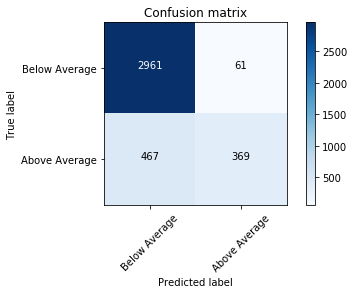

In [10]:
#visualize the confusion matrix (using one of my helper functions)
cm = confusion_matrix(y_test, y_pred)
classes = ["Below Average", "Above Average"]
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

Ok, this isn't terrible. Looks like quite a few type II errors, but not too many type I - that's what I want!

Lets look at all the metrics

In [11]:
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [12]:
# look at accuracy:
print(f'Classification Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# check null accuracy:
print(f'Null Accuracy: {max(y_test.mean(), 1 - y_test.mean())}')
# check precision
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
# check recall
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
# check specificity
print(f'Specificity: {(TN/float(TN+FP))}')
# check false positive rate
print(f'False Positive Rate: {FP/float(TN+FP)}')
# check F1
print(f'F1 Score: {(metrics.f1_score(y_test, y_pred))}')

Classification Accuracy: 0.8631415241057543
Null Accuracy: 0.7833074131674442
Precision: 0.858139534883721
Recall: 0.44138755980861244
Specificity: 0.9798146922567836
False Positive Rate: 0.02018530774321641
F1 Score: 0.5829383886255923


**Optimize for precision &/or specificity**

# I'm going to 'SMOTE' my classes as they are very uneven

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm_train, y_sm_train = smote.fit_resample(X_train, y_train)

In [14]:
#repeat the logreg to see what happened
logreg = LogisticRegression()
logreg.fit(X_sm_train, y_sm_train)
y_pred = logreg.predict(X_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [16]:
# look at accuracy:
print(f'Classification Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# check null accuracy:
print(f'Null Accuracy: {max(y_test.mean(), 1 - y_test.mean())}')
# check precision
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
# check recall
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
# check specificity
print(f'Specificity: {(TN/float(TN+FP))}')
# check false positive rate
print(f'False Positive Rate: {FP/float(TN+FP)}')
# check F1
print(f'F1 Score: {(metrics.f1_score(y_test, y_pred))}')

Classification Accuracy: 0.7864178330741317
Null Accuracy: 0.7833074131674442
Precision: 0.5063157894736842
Recall: 0.5753588516746412
Specificity: 0.8448047650562541
False Positive Rate: 0.15519523494374587
F1 Score: 0.5386338185890257


# Scale my data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=38)
scaler = StandardScaler()  
scaler.fit(X_train)

Xs_train = scaler.transform(X_train)  
Xs_test = scaler.transform(X_test)

# Building a decision tree.

In [18]:
# fitting my data to a decision tree classifier
ctree=DecisionTreeClassifier(max_depth = 3)
ctree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

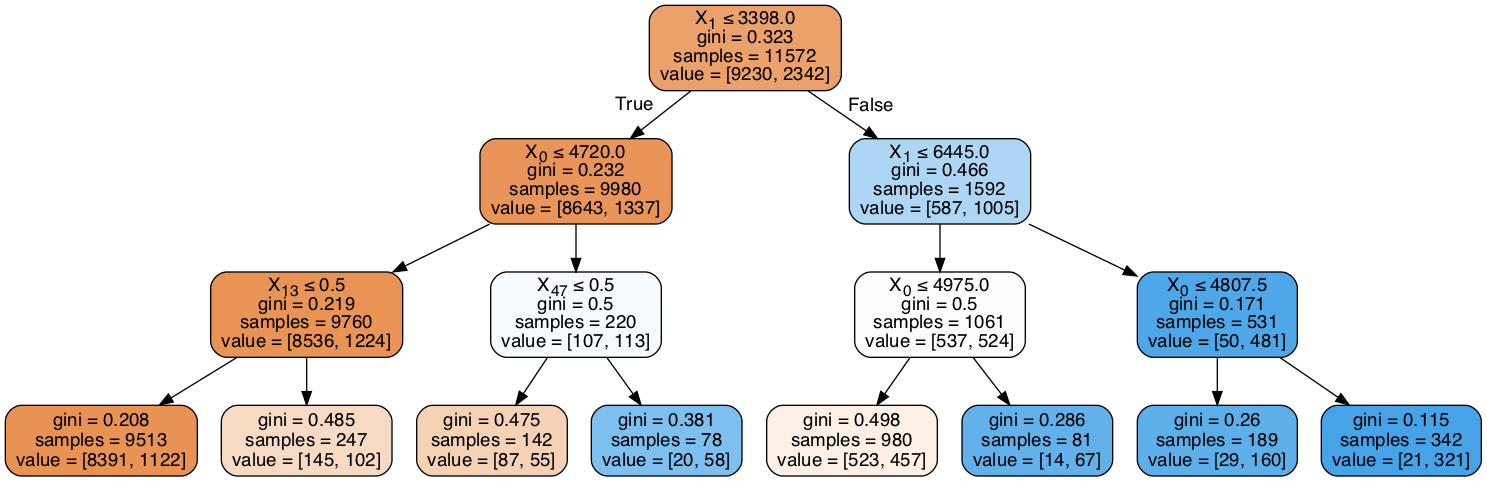

In [19]:
# visualizing my tree
dot_data = StringIO()
export_graphviz(ctree, out_file=dot_data,  
                rounded=True, filled=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [20]:
y_pred = ctree.predict(X_test)

I'm going to stop this here for now and jump to random forest as that was my best one and I really want to dig into that.

# Random Forest

In [21]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [22]:
# check the mean accuracy
print(f'Training accuracy: {forest.score(X_train, y_train)}')
print(f'Testing accuracy: {forest.score(X_test, y_test)}')

Training accuracy: 0.964828897338403
Testing accuracy: 0.8652151373768792


In [42]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.figure(figsize=(12,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

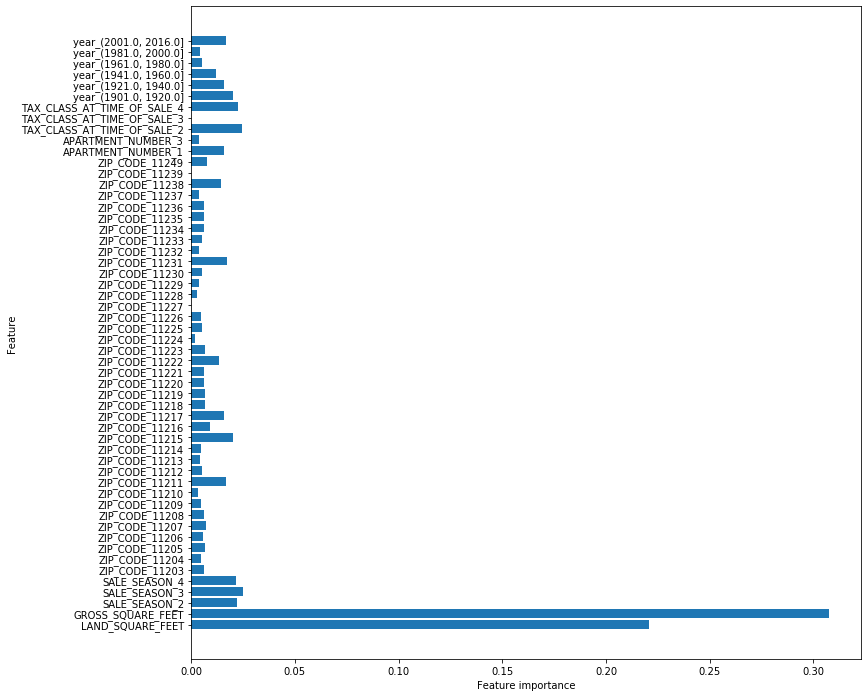

In [25]:
plot_feature_importances(forest)

In [27]:
# gridsearch to tune hyperparameters
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [28]:
# now I'll initialize my starting ranges
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 99, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [29]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100,
                                                    n_jobs=None,
 

In [30]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 36,
 'bootstrap': True}

In [31]:
hyp_forest = RandomForestClassifier(n_estimators= 800, min_samples_split= 5, min_samples_leaf= 1, 
                                    max_features= 'sqrt', max_depth= 36, bootstrap= True, random_state=42)

In [32]:
hyp_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=36, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [33]:
# check the mean accuracy
print(f'Training accuracy: {hyp_forest.score(X_train, y_train)}')
print(f'Testing accuracy: {hyp_forest.score(X_test, y_test)}')

Training accuracy: 0.9358797096439682
Testing accuracy: 0.8722135821669259


In [34]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [25, 30, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2,5,10],
    'n_estimators': [400, 600, 800, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [35]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  5.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [36]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 800}

In [37]:
best_forest = RandomForestClassifier(n_estimators= 800, min_samples_split= 10, min_samples_leaf= 1, 
                                    max_features= 3, max_depth= 40, bootstrap= True, random_state=42)

In [38]:
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
# check the mean accuracy
print(f'Training accuracy: {best_forest.score(X_train, y_train)}')
print(f'Testing accuracy: {best_forest.score(X_test, y_test)}')

Training accuracy: 0.9179917041133772
Testing accuracy: 0.8701399688958009


In [40]:
print(f'Score improved with hyperparameter tuning by {round(100*((best_forest.score(X_test, y_test)-forest.score(X_test, y_test))/forest.score(X_test, y_test)),2)}%')

Score improved with hyperparameter tuning by 0.57%


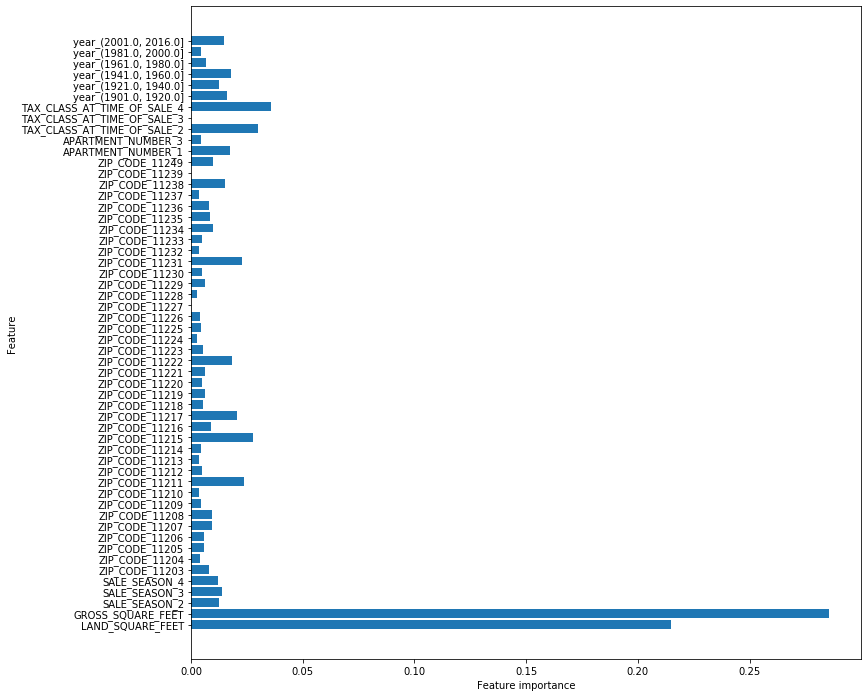

In [43]:
#have a look at the feature importance
plot_feature_importances(best_forest)